# 0.0 Imports

In [55]:
import numpy as np
import pandas as pd
import inflection
import math
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from scipy import stats  as ss
import random
import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## 0.1 Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining,ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation),np.expm1(yhat))

        # store performance of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {'Model Name': model_name,
         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [3]:
# Load datasets
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge datasets
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left',on='Store')

In [4]:
# dataset with sales informations
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
# dataset with store attributes
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# dataset with all data
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. Data Description

In [7]:
df1 = df_raw.copy()

In [8]:
list(df_raw.columns)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

**Id** - an Id that represents a (Store, Date) duple within the test set

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# lowercase
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 - Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# date to datetime
df1['date'] = pd.to_datetime(df1['date'])

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [15]:
df1.sample(1)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
823738,539,7,2013-06-23,0,0,0,0,0,0,a,a,770.0,5.0,2013.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [16]:
# competition_distance              
# Se vazio, não há competidor mais próximo (a distancia até o competidor é mto grande)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2*10**5 if math.isnan(x) else x)

# competition_open_since_month
# Se vazio, considerar a data da primeira compra 
df1['competition_open_since_month'] = df1[['competition_open_since_month','date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
df1['competition_open_since_year'] = df1[['competition_open_since_year','date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1[['promo2_since_week','date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['promo2_since_year','date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
# Se promo_interval for igual a zero, a loja não participou da promoção estendida em nenhum momento
# se o promo_interval in month_map, a loja estava em promoção estendida no momento da venda
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Out',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [17]:
df1.sample(5).T

,175410,718638,313284,442186,956598
store,356,249,289,317,714
day_of_week,2,3,5,6,7
date,2015-02-24 00:00:00,2013-09-25 00:00:00,2014-10-10 00:00:00,2014-05-31 00:00:00,2013-02-24 00:00:00
sales,4316,5076,6858,6282,0
customers,374,480,606,659,0
open,1,1,1,1,0
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,d,d,d,d


## 1.6 Change Types

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

In [22]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

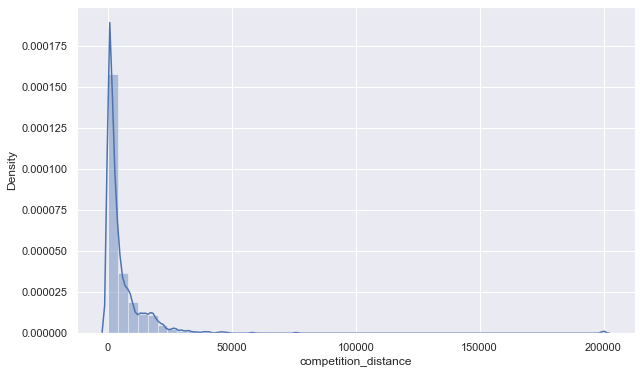

In [23]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [24]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

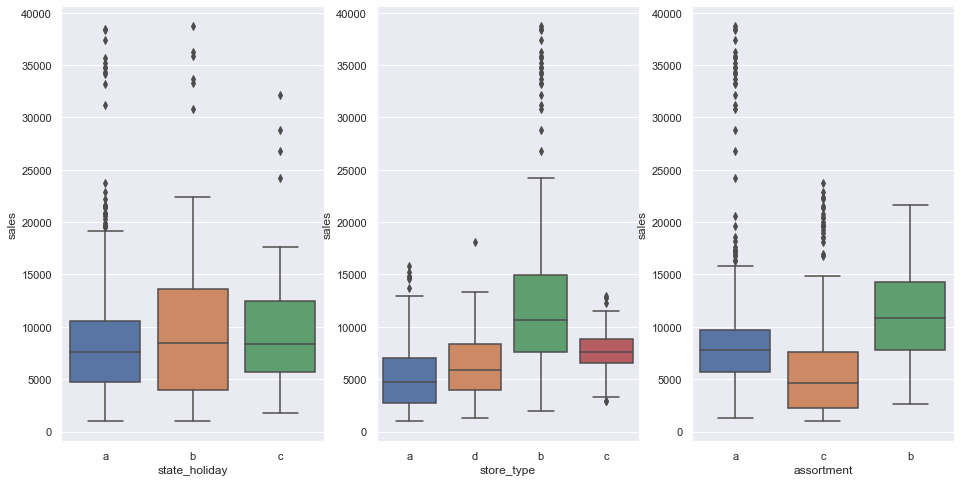

In [25]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16,8))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales' , data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type' , y='sales' , data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment' , y='sales' , data=aux1)

# 2.0. Feature Engeneering

In [26]:
df2 = df1.copy()

## 2.1 - Hypothesis Mind Map

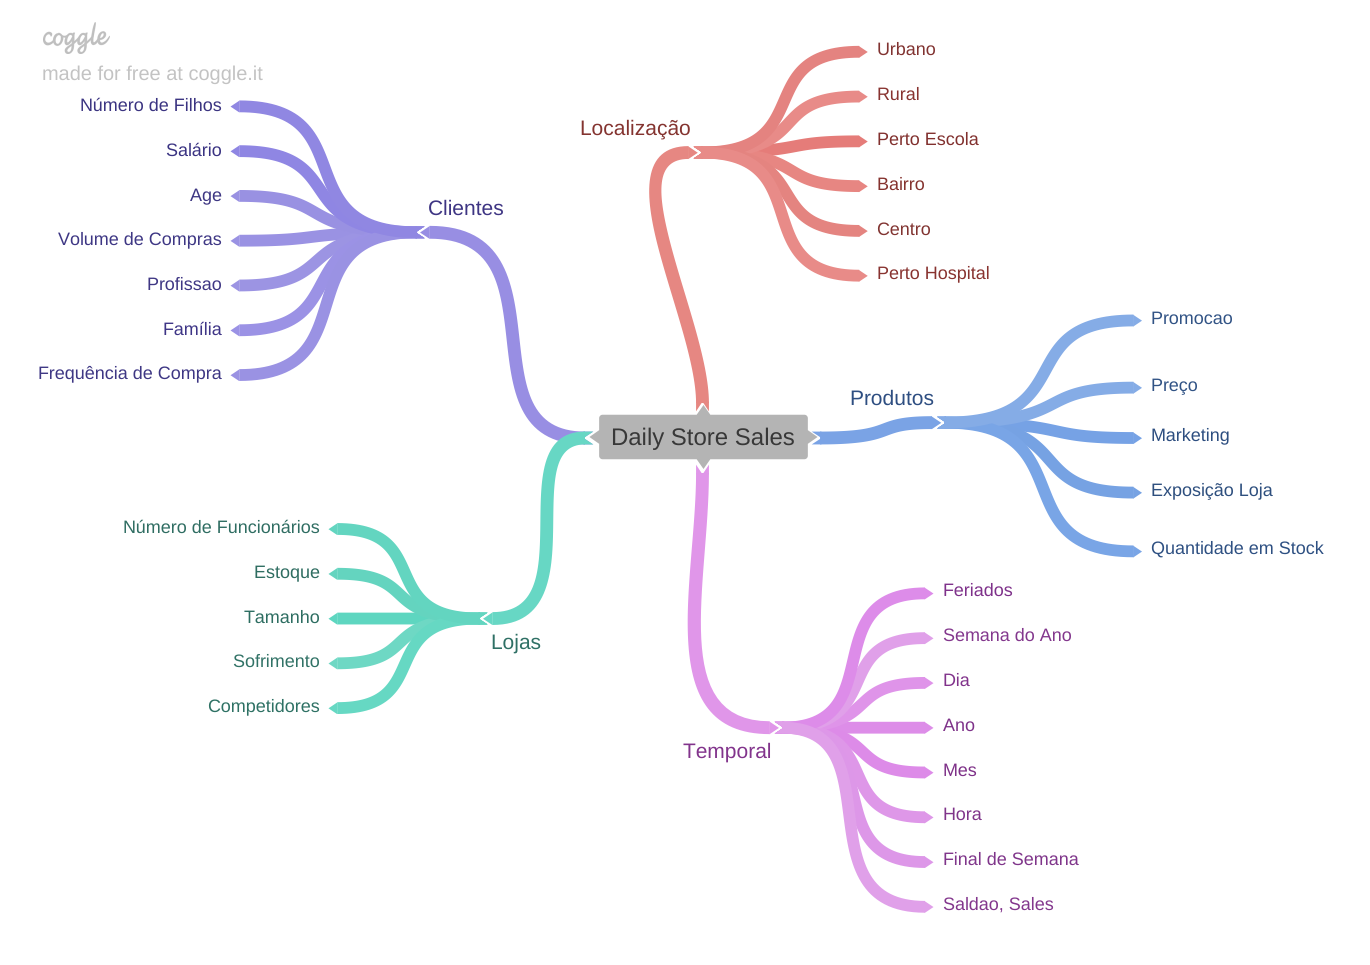

In [27]:
Image('img/Daily_Store_Sales.png')

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipóteses Loja

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Final Hypothesis List

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of day
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days) # time over the initial of promotion

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x =='c' else 'regular_day') 

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [30]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 3.0. Variable Filtering

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [34]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In [36]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

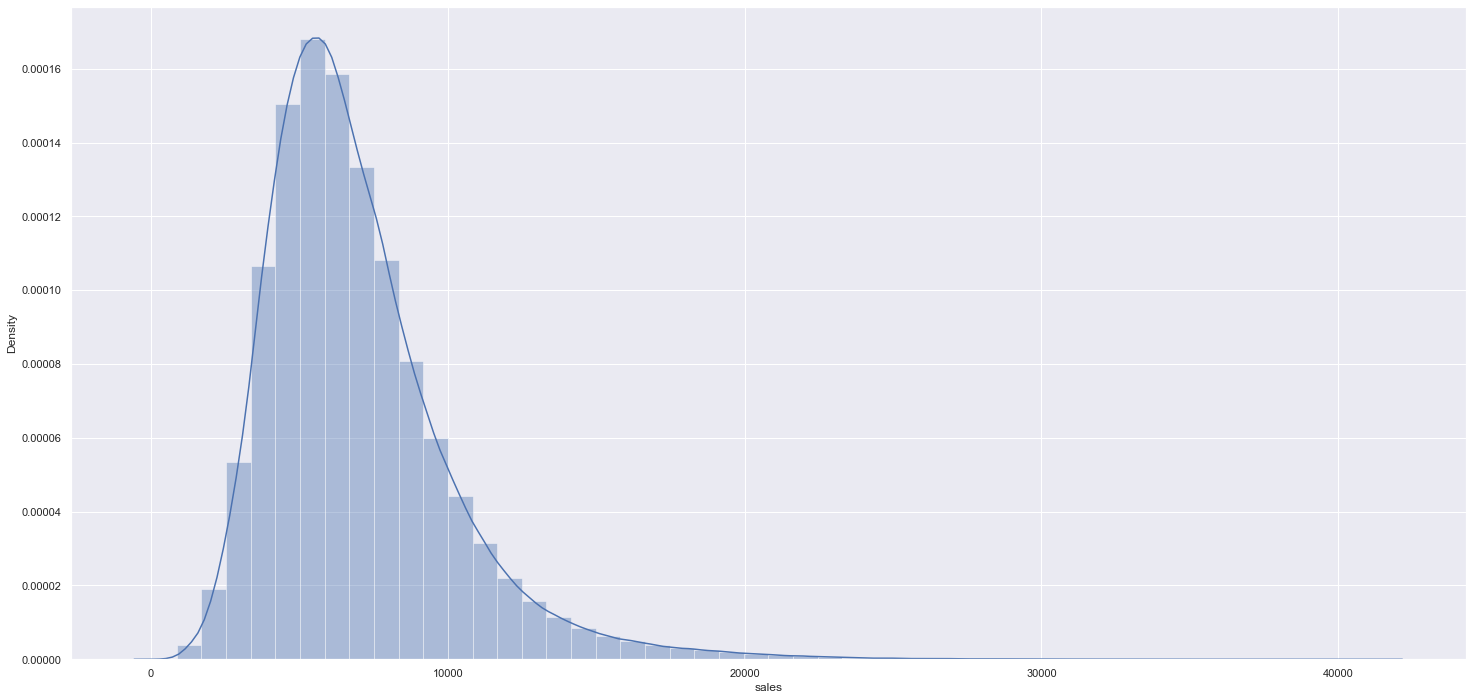

In [37]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

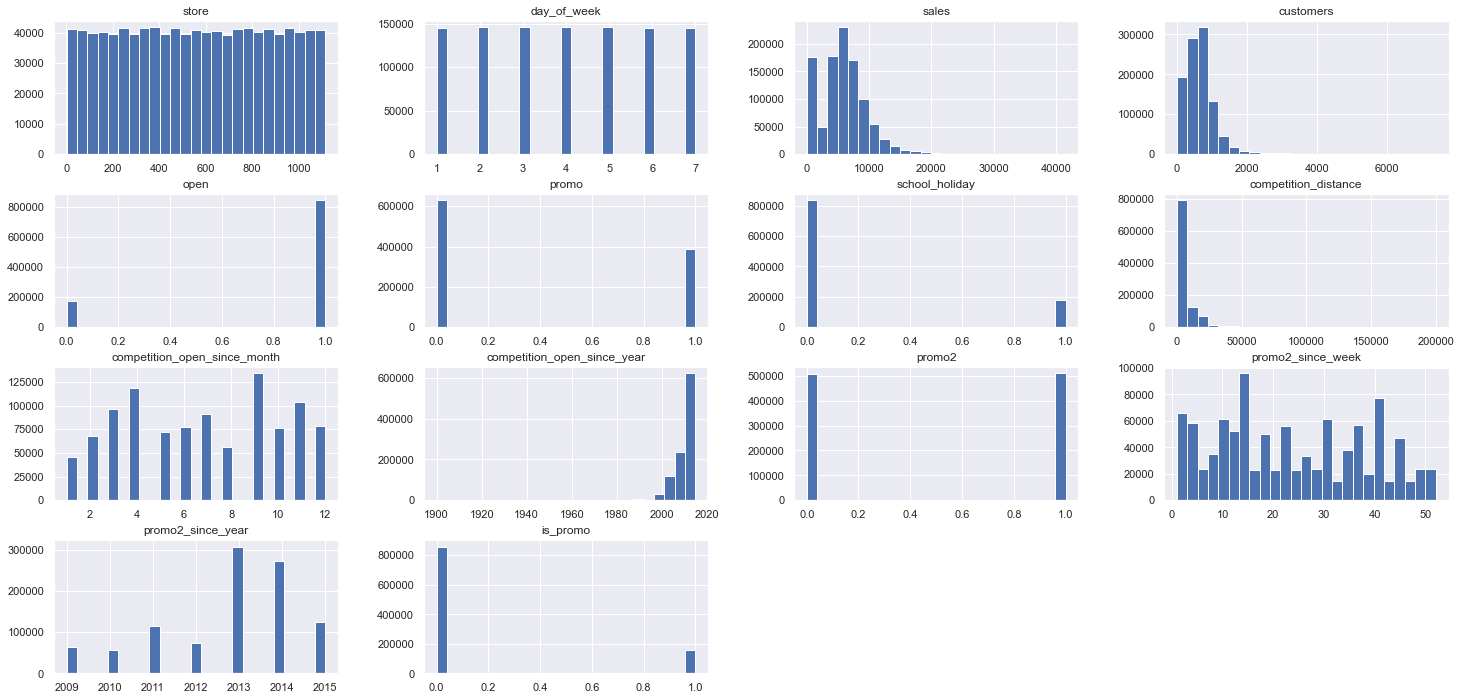

In [38]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [39]:
df4['state_holiday'].value_counts(normalize=True)

regular_day       0.998922
public_holiday    0.000822
easter_holiday    0.000172
christmas         0.000084
Name: state_holiday, dtype: float64

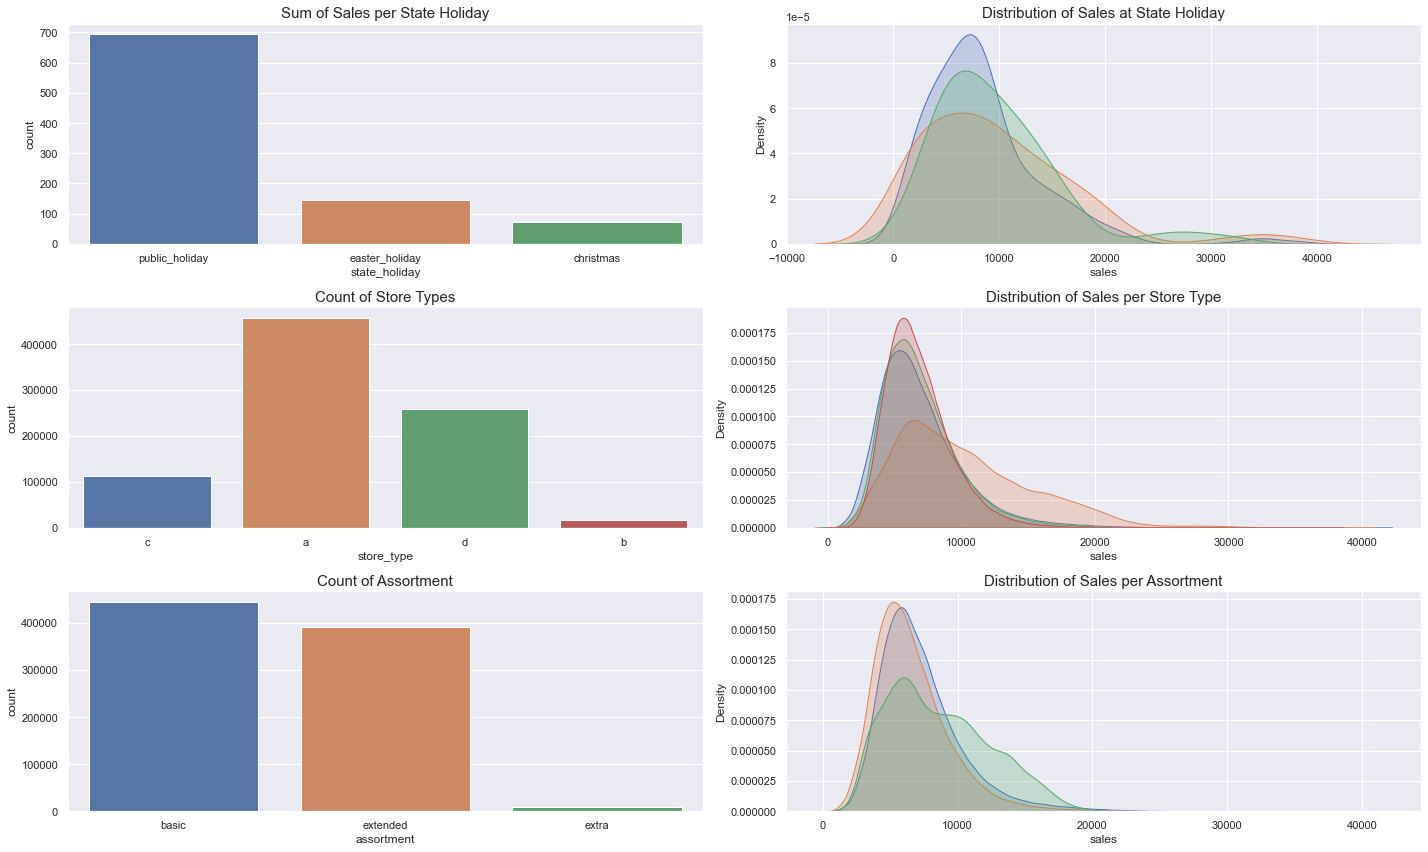

In [40]:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
plt.title('Sum of Sales per State Holiday',fontsize=15)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
plt.title('Distribution of Sales at State Holiday',fontsize=15)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas',shade=True)

plt.subplot(3,2,3)
plt.title('Count of Store Types',fontsize=15)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
plt.title('Distribution of Sales per Store Type',fontsize=15)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d',shade=True)

plt.subplot(3,2,5)
plt.title('Count of Assortment',fontsize=15)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
plt.title('Distribution of Sales per Assortment',fontsize=15)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended',shade='True')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade='True')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade='True')

plt.tight_layout()

## 4.2. Análise Bivariada

### **H1.** Lojas com maior variedade de produtos, em média, deveriam vender mais.

Verdadeiro. Lojas com maior diversidade de produtos vendem 18% mais em média que as lojas com diversidade estendida


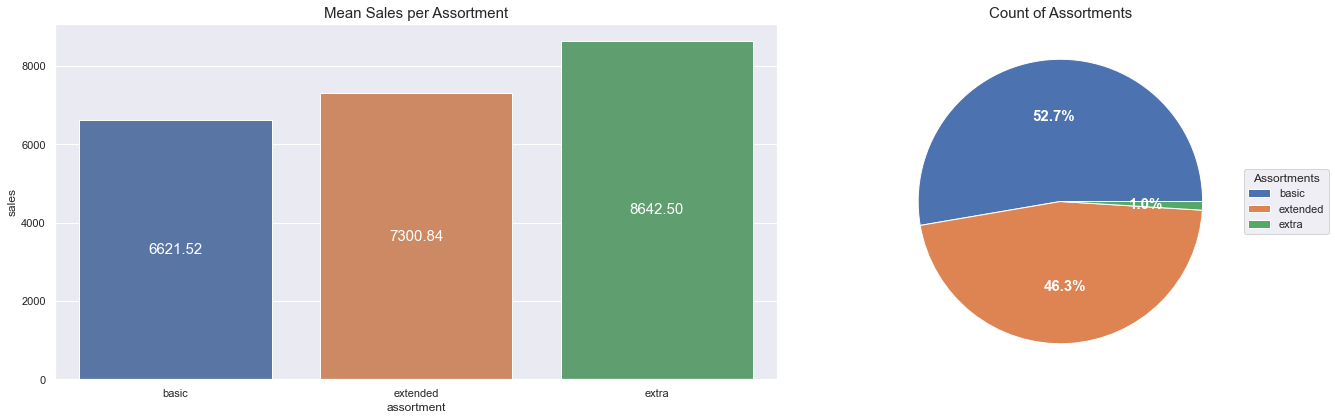

In [51]:
grid = GridSpec(1,2)

plt.figure(figsize=(20,6))

# bar plot
plt.subplot(grid[0,0])
plt.title('Mean Sales per Assortment',fontsize=15)
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
aux1['AoA'] = aux1['sales'].rolling(window=2).apply( lambda x: round((x.iloc[1] / x.iloc[0] -1) * 100,2) )
g = sns.barplot(x='assortment',y='sales',data=aux1)

# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='white', label_type= 'center',fontsize=15,fmt='%.2f')

# pie plot
ax = plt.subplot(grid[0,1])
aux2 = pd.DataFrame(df4['assortment'].value_counts()).reset_index()
wedges, texts, autotexts = ax.pie( data = aux2,
                                   x = 'assortment',
                                   autopct = lambda x: str(round(float(x),1)) + "%",
                                   textprops = dict(color="w"))
ax.legend( wedges, list(aux2['index']),
          title = "Assortments",
          loc="center left",
          bbox_to_anchor = (1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold")
ax.set_title("Count of Assortments",fontsize = 15);

plt.savefig("img//H1.png",dpi=600)
plt.tight_layout()

print(f'Verdadeiro. Lojas com maior diversidade de produtos vendem 18% mais em média que as lojas com diversidade estendida')


### **H2.** Lojas com competidores mais próximos deveriam vender menos.

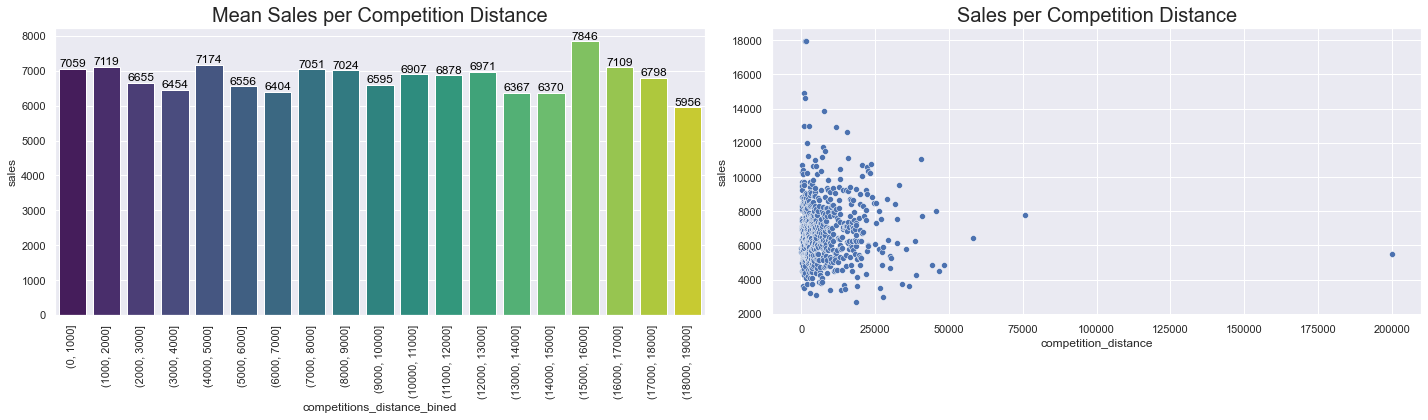

In [49]:
grid = GridSpec(1,2)

plt.figure(figsize=(20,6))

plt.subplot(grid[0,0])

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list(np.arange(0,20000,1000))
aux1['competitions_distance_bined'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competitions_distance_bined','sales']].groupby('competitions_distance_bined').mean().reset_index()

# bar plot
g = sns.barplot(x='competitions_distance_bined',y='sales',data=aux2,palette='viridis')
plt.title('Mean Sales per Competition Distance',size=20)
plt.xticks(rotation=90)
# incluindo labels nas barras
for i in g.containers:
    g.bar_label(i, color='black', label_type= 'edge',fontsize=12,fmt='%.0f',rotation=0)

# scatter plot
plt.subplot(grid[0,1])
sns.scatterplot(x='competition_distance', y='sales',data=aux1);
plt.title('Sales per Competition Distance',size=20)
plt.tight_layout()
plt.savefig("img//H2.png",dpi=300)

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.

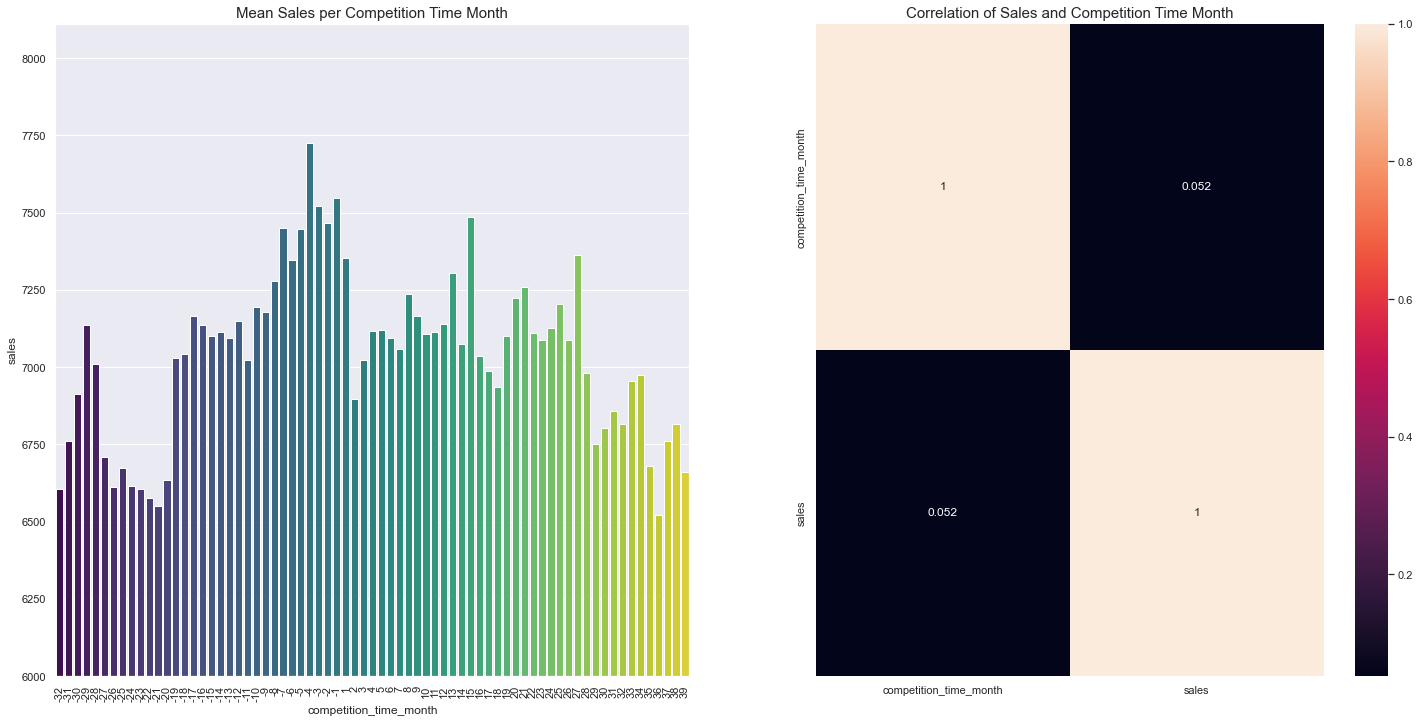

In [44]:
grid = GridSpec(1,2)

plt.subplot( grid[0,0] )
plt.title( 'Mean Sales per Competition Time Month', fontsize = 15 )
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 40 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2, palette = 'viridis');
plt.xticks( rotation = 90 )
plt.ylim( bottom = 6000 )

plt.subplot(grid[0,1])
plt.title('Correlation of Sales and Competition Time Month', fontsize = 15)
sns.heatmap( aux2.corr(method='pearson'), annot = True);

plt.savefig("img//H3.png",dpi=300)

# plt.subplot(grid[1,:])
# plt.title('Tendence of Sales per Competition Time Month', fontsize=15)
# sns.regplot(x='competition_time_month', y='sales',data=aux2);
# plt.tight_layout()

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

Verdadeiro. Lojas com promoções ativas por mais tempo possuem um tendencia de crescimento nas vendas ao longo das semanas


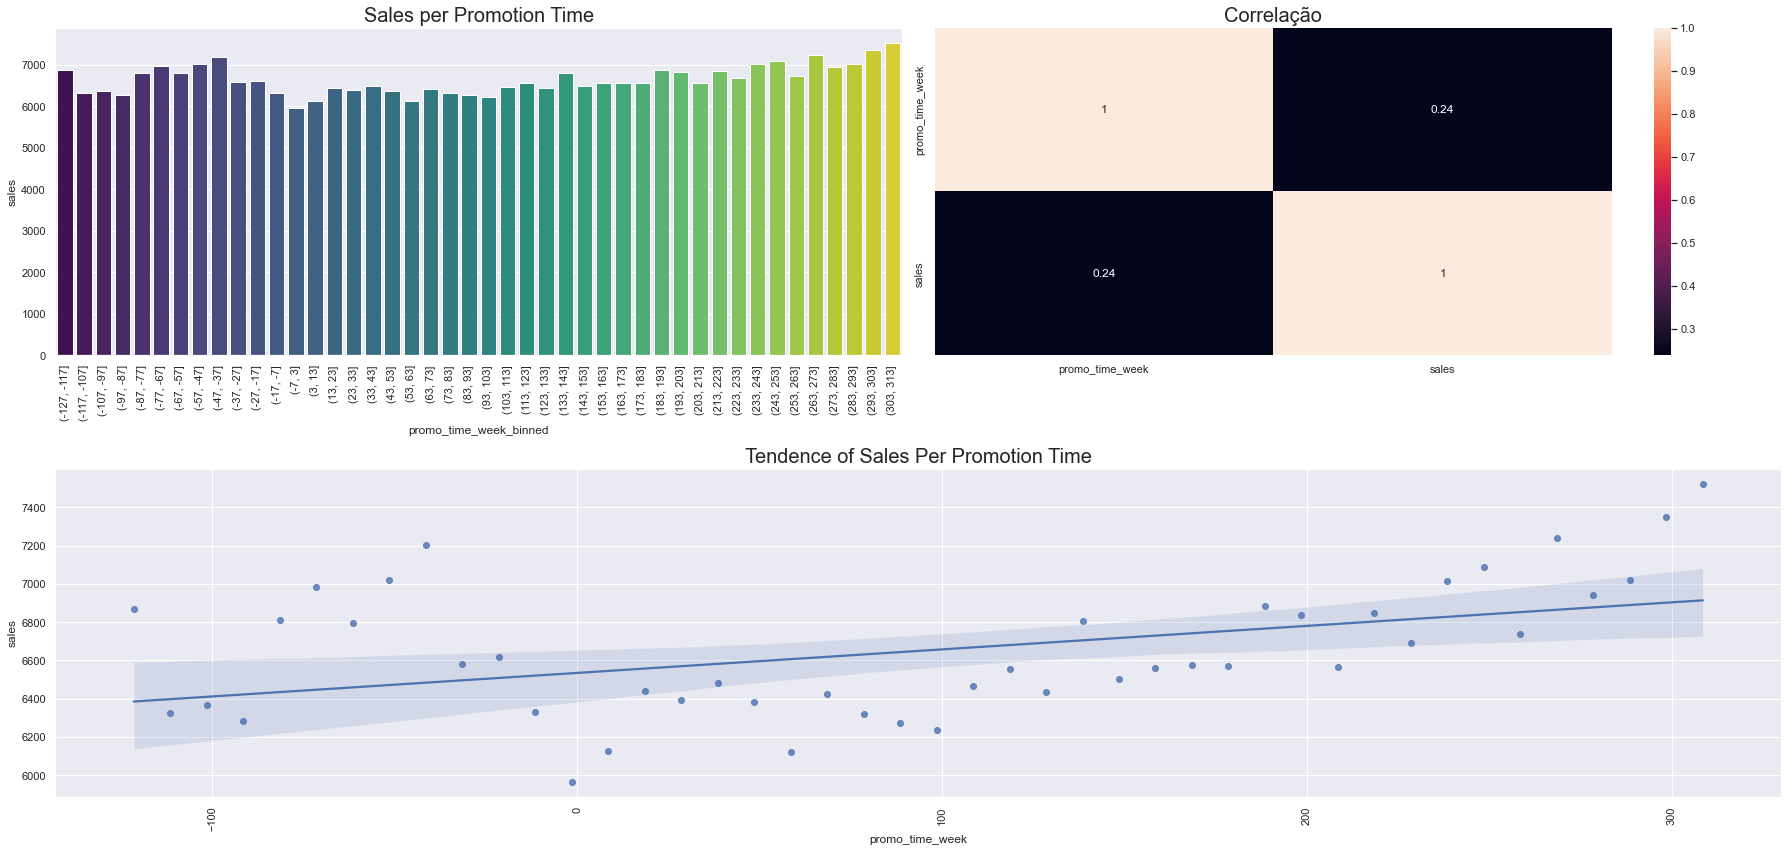

In [45]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

bins = list(np.arange(aux1['promo_time_week'].min()-1,aux1['promo_time_week'].max()+1,10))
aux1['promo_time_week_binned'] = pd.cut(aux1['promo_time_week'],bins=bins)

aux2 = aux1.groupby('promo_time_week_binned').mean().reset_index()

grid = GridSpec(2,2)

plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week_binned', y='sales', data=aux2, palette='viridis');
plt.title('Sales per Promotion Time',fontsize=20)
plt.xticks(rotation=90);
plt.tight_layout()

plt.subplot(grid[1,:])
sns.regplot(x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90);
plt.title('Tendence of Sales Per Promotion Time',fontsize=20)
plt.tight_layout()

plt.subplot(grid[0,1])
sns.heatmap(aux1.corr(method='pearson'),annot=True);
plt.title('Correlação',fontsize=20)
plt.tight_layout()
plt.savefig("img//H4.png",dpi=300)

print(f'Verdadeiro. Lojas com promoções ativas por mais tempo possuem um tendencia de crescimento nas vendas ao longo das semanas')

### **H5.** Lojas com mais dias de promoção deveriam vender mais.

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.

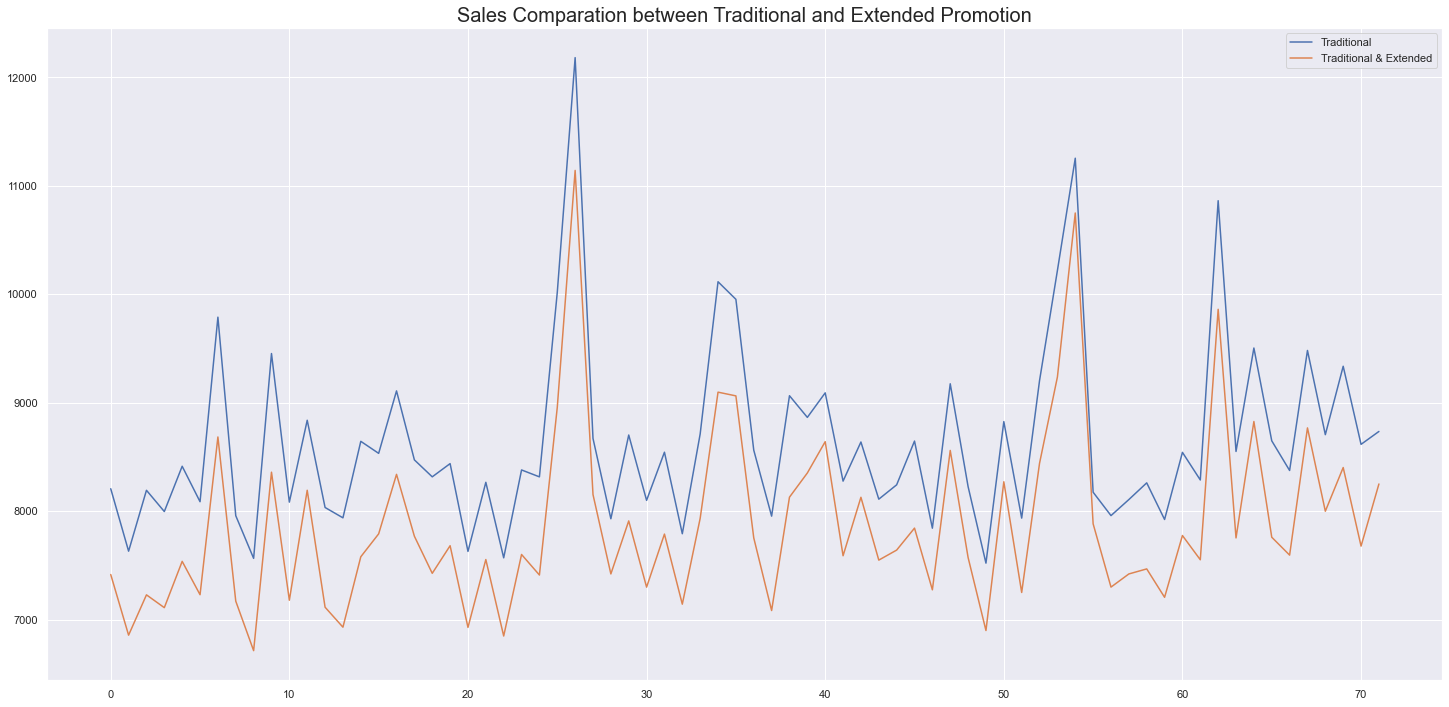

In [46]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()

ax = aux1.plot()
aux2.plot(ax=ax)

plt.title('Sales Comparation between Traditional and Extended Promotion',fontsize=20)
ax.legend(labels=['Traditional','Traditional & Extended'])
plt.savefig("img//H7.png",dpi=300)

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.

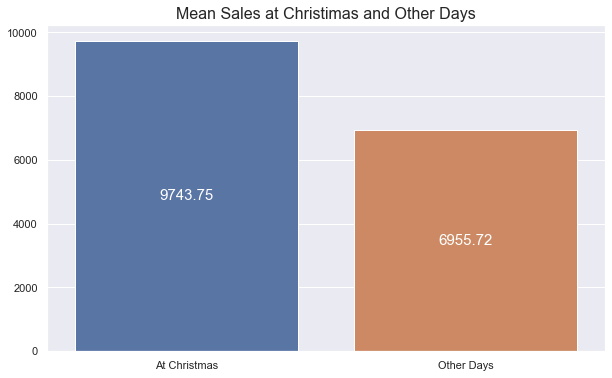

In [47]:
sales_on_christmas = df4[df4['state_holiday'] == 'christmas']['sales'].mean()
sales_others_days = df4[df4['state_holiday'] != 'christmas']['sales'].mean()

fig = plt.figure(figsize=(10,6))
g = sns.barplot(x=['At Christmas','Other Days'],y=[sales_on_christmas,sales_others_days])
plt.title('Mean Sales at Christimas and Other Days',fontsize=16)

for i in g.containers:
    g.bar_label(i,color='white', label_type= 'center',fontsize=15,fmt='%.2f')

plt.savefig("img//H8.png",dpi=300)

### H9. Lojas deveriam vender mais ao longo dos anos.

VERDADEIRO. Ao longo dos anos o crescimento médio das vendas é de 2.0%


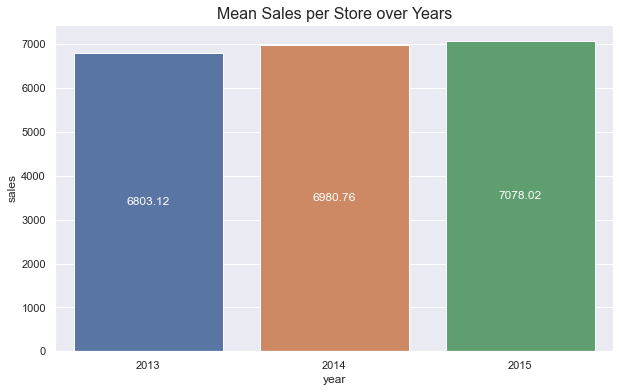

In [48]:
aux1 = df4[['year','store','sales']].groupby(['year','store']).mean().reset_index()
sales_per_year = aux1[['year','sales']].groupby('year').mean().reset_index()
sales_per_year['YoY'] = sales_per_year['sales'].rolling(window=2).apply( lambda x: round((x.iloc[1] / x.iloc[0] -1) * 100,2) )

fig = plt.figure(figsize=(10,6))
plt.title('Mean Sales per Store over Years',fontsize=16)
g = sns.barplot(x='year',y='sales',data=sales_per_year)

for i in g.containers:
    g.bar_label(i,color='white',label_type='center')
    
plt.savefig("img//H9.png",dpi=300)

YoY_mean = sales_per_year['YoY'].mean()

print(f'VERDADEIRO. Ao longo dos anos o crescimento médio das vendas é de {YoY_mean}%')


### H10. Lojas deveriam vender mais no segundo semestre do ano.

VERDADEIRO. No 2º semestre as vendas são 2.71% maior que no 1º semestre


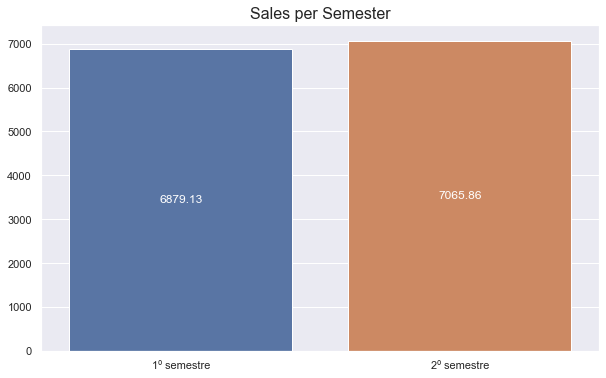

In [49]:
S1 = df4[df4['month'] <= 6]['sales'].mean() 
S2 = df4[df4['month'] > 6]['sales'].mean()

diff = (S2 - S1)

fig = plt.figure(figsize=(10,6))
plt.title('Sales per Semester',fontsize=16)
g = sns.barplot(x=['1º semestre','2º semestre'],y=[S1,S2])

for i in g.containers:
    g.bar_label(i, color='white',label_type='center')
    
print(f'VERDADEIRO. No 2º semestre as vendas são {round(diff*100/(S1),2)}% maior que no 1º semestre')

plt.savefig("img//H10.png",dpi=300)

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.

Após o dia 10, as vendas são em média 8% menores


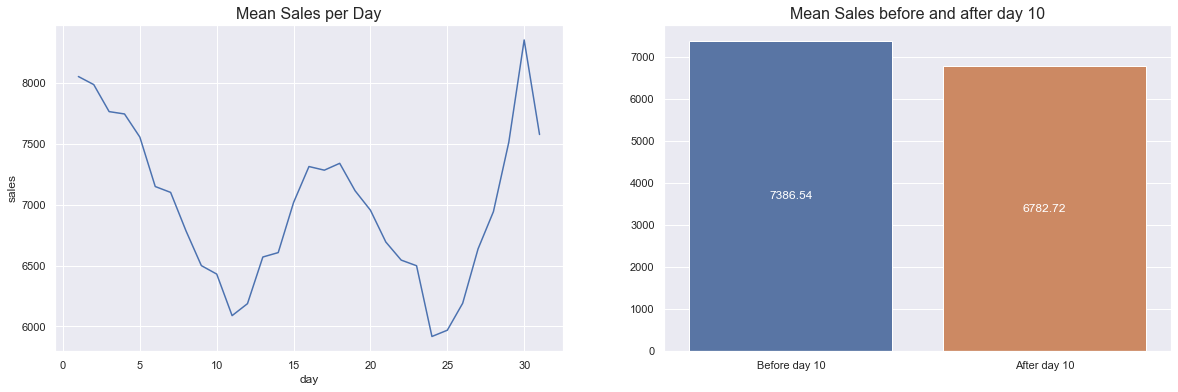

In [50]:
grid = GridSpec(1,2)

fig = plt.figure(figsize=(20,6))
plt.subplot(grid[0,0])

aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
sns.lineplot(x='day',y='sales',data=aux1)
plt.title('Mean Sales per Day',fontsize=16)

plt.subplot(grid[0,1])

sales_before_10d = df4[df4['day'] < 10]['sales'].mean()
sales_after_10d = df4[df4['day'] >= 10]['sales'].mean()
diff = sales_before_10d - sales_after_10d

print(f'Após o dia 10, as vendas são em média {round(diff*100/sales_before_10d)}% menores')

plt.title('Mean Sales before and after day 10',fontsize=16)
g = sns.barplot(x=['Before day 10', 'After day 10'],y=[sales_before_10d,sales_after_10d])
for i in g.containers:
    g.bar_label(i, color='white',label_type='center')
    
plt.savefig("img//H11.png",dpi=300)

### H12. Lojas deveriam vender menos aos finais de semana.

As vendas nos fim de semana são até 22.58% maiores que nos dias úteis


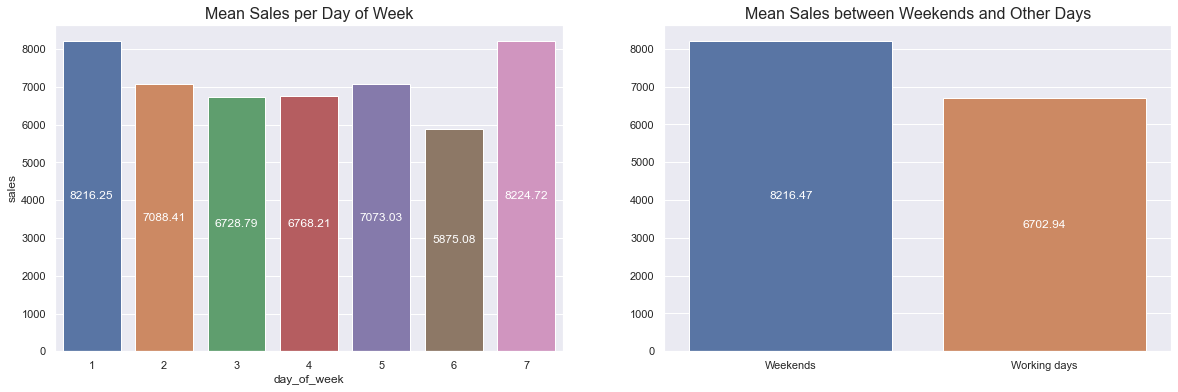

In [51]:
grid = GridSpec(1,2)
fig = plt.figure(figsize=(20,6))

plt.subplot(grid[0,0])
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()
g = sns.barplot(x='day_of_week',y='sales',data=aux1)
plt.title('Mean Sales per Day of Week', fontsize=16)
for i in g.containers:
    g.bar_label(i,color='white',label_type='center')

plt.subplot(grid[0,1])

sales_on_weekend = df4[(df4['day_of_week'] == 1) | (df4['day_of_week'] == 7)]['sales'].mean()
sales_on_weekday = df4[(df4['day_of_week'] != 1) & (df4['day_of_week'] != 7)]['sales'].mean()
diff = sales_on_weekend - sales_on_weekday

g = sns.barplot(x=['Weekends','Working days'],y=[sales_on_weekend,sales_on_weekday])
plt.title('Mean Sales between Weekends and Other Days',fontsize=16)
for i in g.containers:
    g.bar_label(i,color='white',label_type='center')
    
print(f'As vendas nos fim de semana são até {round(diff*100/sales_on_weekday,2)}% maiores que nos dias úteis')

plt.savefig("img//H12.png",dpi=300)

### H13. Lojas deveriam vender menos durante os feriados escolares.

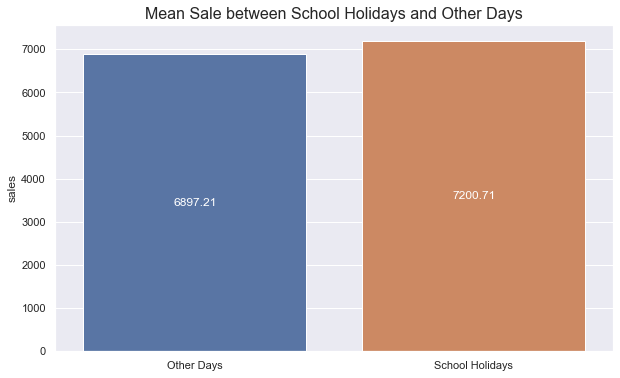

In [52]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()

fig = plt.figure(figsize=(10,6))
plt.title('Mean Sale between School Holidays and Other Days',fontsize=16)
g = sns.barplot(x=['Other Days','School Holidays'],y='sales',data=aux1)
for i in g.containers:
    g.bar_label(i,color='white',label_type='center')
    
plt.savefig("img//H13.png",dpi=300)

## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

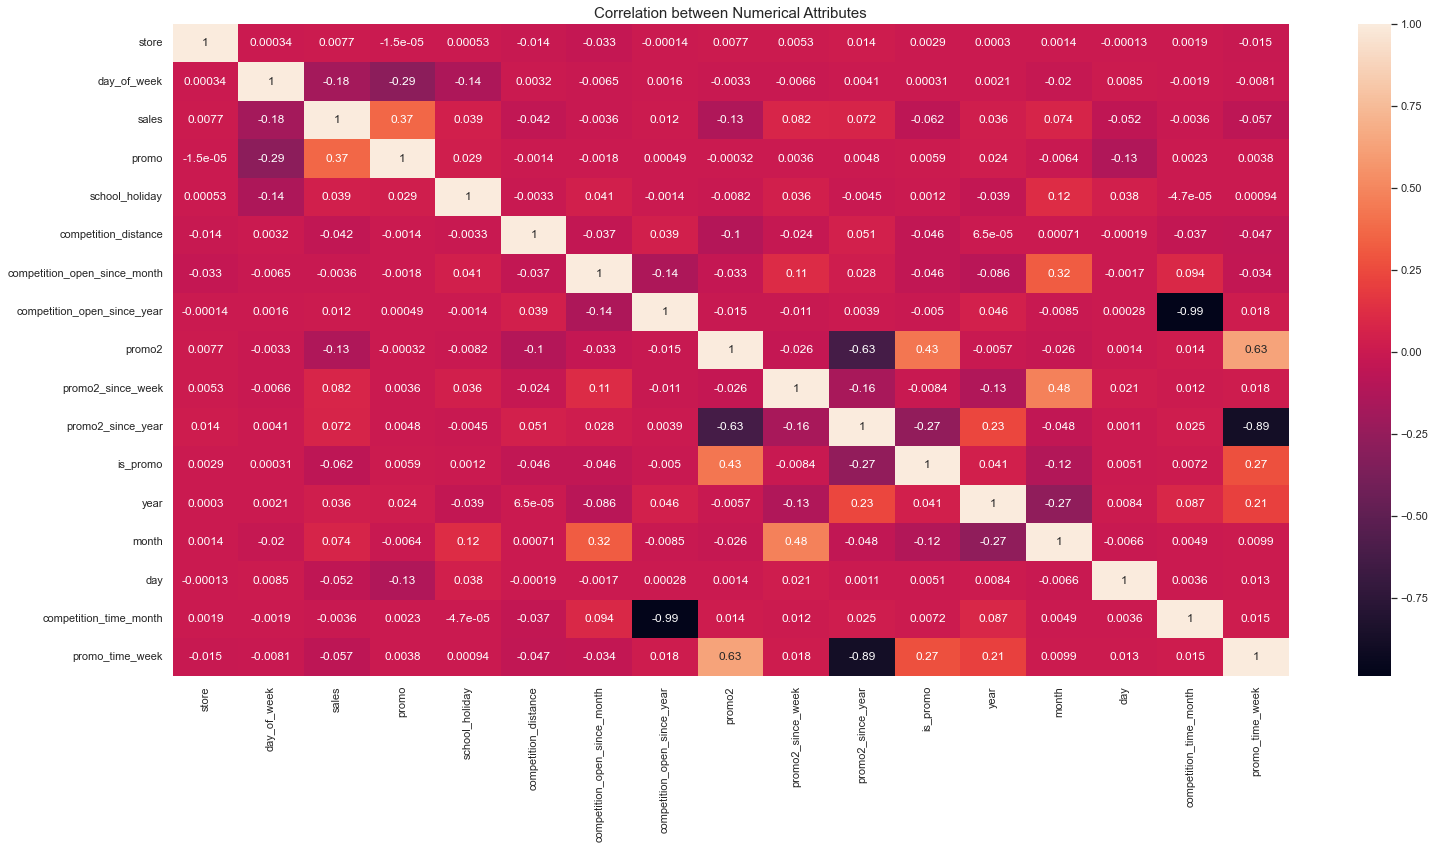

In [53]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
correlations = num_attributes.corr(method='pearson')
plt.title('Correlation between Numerical Attributes',fontsize=15)
sns.heatmap(correlations,annot=True);

### 4.3.2 Categorical Attributes

In [54]:
a = df4.select_dtypes(include='object')

In [55]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


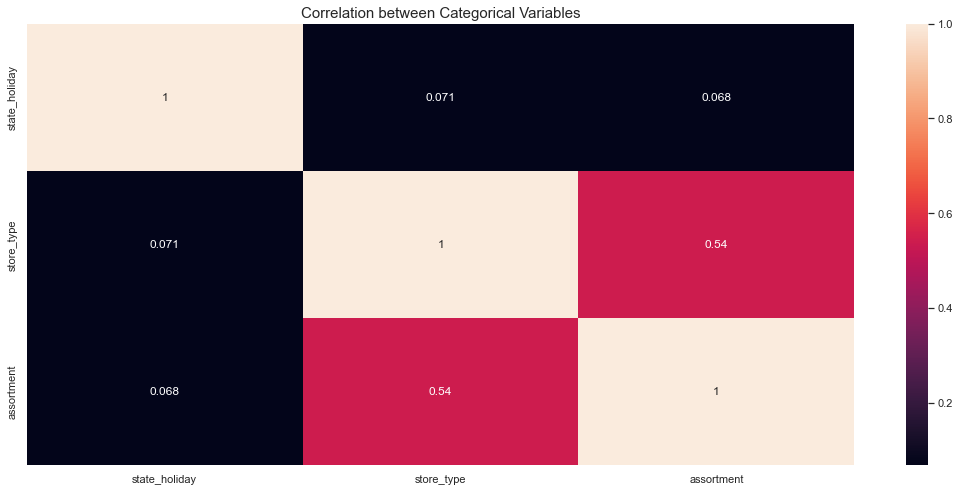

In [56]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

plt.figure(figsize=(15,7))
plt.title('Correlation between Categorical Variables',fontsize=15)
sns.heatmap( d, annot=True )
plt.tight_layout()

# 5.0. Data Preparation

In [58]:
df5 = df4.copy()

## 5.1. Normalization

In [59]:
# Como os dados não possuem uma distribuição normal, não faz sentido aplicarmos esse metodo

## 5.2. Rescaling

In [60]:
a = df5.select_dtypes(include=['int64','float64'])
a.head().T

,0,1,2,3,4
store,1.0,2.0,3.0,4.0,5.0
day_of_week,5.0,5.0,5.0,5.0,5.0
sales,5263.0,6064.0,8314.0,13995.0,4822.0
promo,1.0,1.0,1.0,1.0,1.0
school_holiday,1.0,1.0,1.0,1.0,1.0
competition_distance,1270.0,570.0,14130.0,620.0,29910.0
competition_open_since_month,9.0,11.0,12.0,9.0,4.0
competition_open_since_year,2008.0,2007.0,2006.0,2009.0,2015.0
promo2,0.0,1.0,1.0,0.0,0.0
promo2_since_week,31.0,13.0,14.0,31.0,31.0


In [61]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import pickle
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs,open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs,open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms,open('parameter/competition_promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms,open('parameter/year_scaler.pkl','wb'))


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

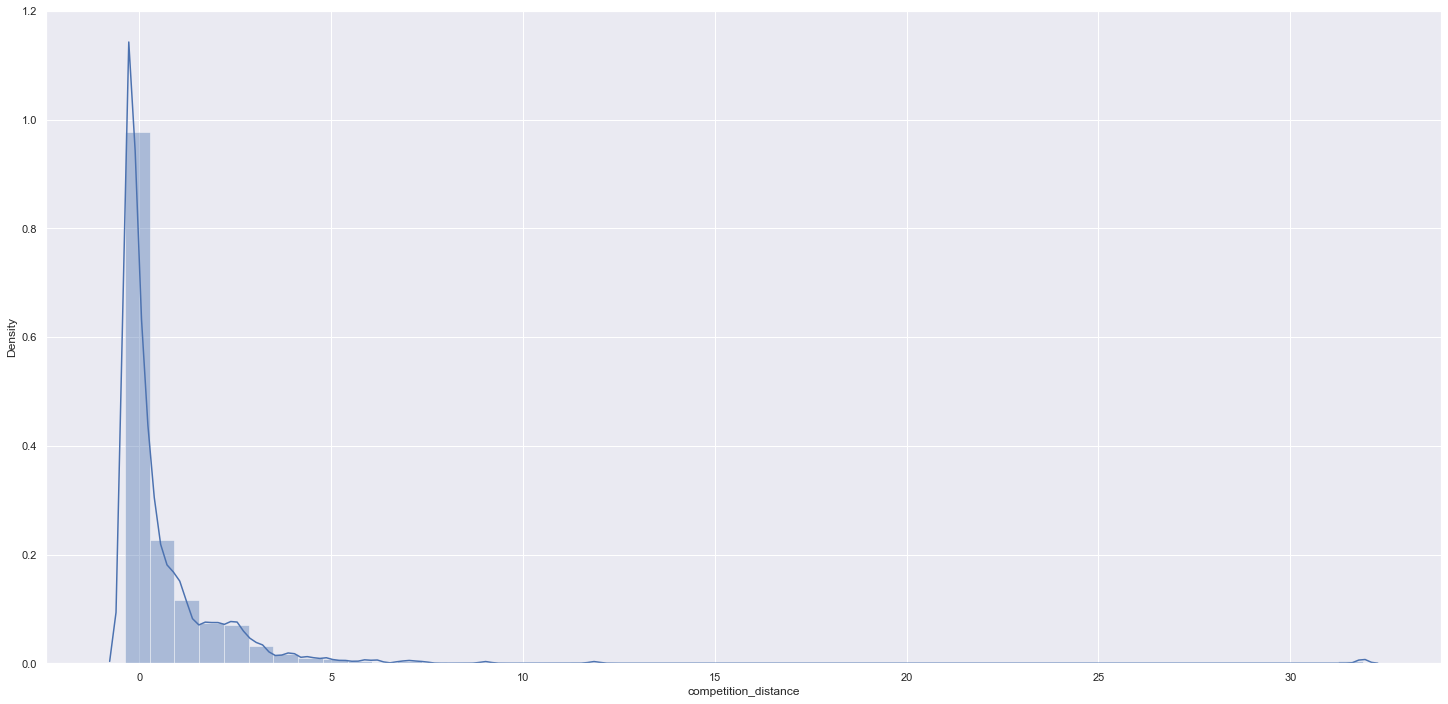

In [62]:
sns.distplot(df5['competition_distance'])

## 5.3. Transformation

### 5.3.1. Enconding

In [63]:
# state holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))

# assortment
assortment_dict = {'basic':1,'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


### 5.3.2. Response variable transformation

In [64]:
df5['sales'] = np.log1p(df5['sales'])

In [65]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.3. Nature transformation

In [66]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

In [67]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. FEATURE SELECTION

In [68]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [69]:
cols_drop = ['day', 'month', 'day_of_week', "week_of_year", 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [70]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [71]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Teste Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Teste Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [72]:
# training and test dataset for boruta
# X_train_n = X_train.drop(['date','sales'],axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs =-1)

# boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n,y_train_n)

### 6.2.1 Best features from boruta

In [73]:
# cols_select = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date','sales'],axis=1)
# cols_select_boruta = X_train_fs.iloc[:, cols_select].columns.tolist()

# not select boruta
# cols_not_select_boruta = np.setdiff1d(X_train_fs.columns, cols_select_boruta)

In [74]:
cols_select_boruta = ['store', 
                      'promo', 
                      'store_type', 
                      'assortment', 
                      'competition_distance', 
                      'competition_open_since_month',
                      'competition_open_since_year',
                      'promo2','promo2_since_week', 
                      'promo2_since_year',
                      'competition_time_month', 
                      'promo_time_week', 
                      'day_of_week_sin',
                      'day_of_week_cos',
                      'month_cos',
                      'month_sin',
                      'day_sin',
                      'day_cos',
                      'week_of_year_cos',
                      'week_of_year_sin']

In [75]:
cols_not_select_boruta = ['is_promo', 
                          'school_holiday',
                          'state_holiday_christmas', 
                          'state_holiday_easter_holiday',
                          'state_holiday_public_holiday', 
                          'state_holiday_regular_day',
                          'year']

In [76]:
# columns to add
feat_to_add = ['date','sales']

# final features
cols_select_boruta_full = cols_select_boruta.copy()
cols_select_boruta_full.extend(feat_to_add)

In [77]:
cols_select_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

# 7.0. Machine Learning Modeling

In [78]:
df7 = df6.copy()

In [79]:
x_train = X_train[cols_select_boruta]
x_test = X_test[cols_select_boruta]

# Time Series Data Preparation
x_training = X_train[cols_select_boruta_full]

## 7.1. Average Model

In [80]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))

## 7.2. Linear Regression Model

In [80]:
## 7.2. Linear Regression Model# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test),np.expm1(yhat_lr))

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [81]:
lr_result_cv = cross_validation(x_training,5,'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98


## 7.3. Lasso Model

In [82]:
# model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test),np.expm1(yhat_lrr))

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [83]:
lrr_result_cv = cross_validation(x_training,5,'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1957.62 +/- 140.52,0.29 +/- 0.0,2828.15 +/- 232.95


## 7.4. Random Forest Regressor

In [85]:
# model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test),np.expm1(yhat_rf))

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.455795,0.099667,1007.9169


### 7.4.1 Random Forest Regressor - Cross Validation

In [88]:
rf_result_cv = cross_validation(x_training,5,'Random Forest', rf, verbose=True)
rf_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,747.02 +/- 133.64,0.11 +/- 0.02,1126.63 +/- 203.71


## 7.5. XGBoost Regressor

In [94]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=2500, 
                              eta=0.01, 
                              max_depth=9, 
                              subsample=0.5,
                              colsample_bytree=0.3 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,797.142725,0.118088,1146.255415


### 7.5.1 XGBoost Regressor - Cross Validation

In [95]:
xgb_result_cv = cross_validation(x_training,5,'XGBooster', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBooster,901.14 +/- 90.25,0.13 +/- 0.01,1308.94 +/- 142.96


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [96]:
pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,Random Forest Regressor,677.455795,0.099667,1007.916900
0,XGBoost Regressor,797.142725,0.118088,1146.255415


### 7.6.2 Real Performance - Cross Validation

In [97]:
pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv]) 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1940.46 +/- 97.24,0.3 +/- 0.02,2735.18 +/- 194.98
0,Lasso,1957.62 +/- 140.52,0.29 +/- 0.0,2828.15 +/- 232.95
0,Random Forest,747.02 +/- 133.64,0.11 +/- 0.02,1126.63 +/- 203.71
0,XGBooster,901.14 +/- 90.25,0.13 +/- 0.01,1308.94 +/- 142.96


## 7.6. Compare Model's Performance

In [111]:
x_training = X_train[cols_select_boruta_full]

In [93]:
# cross_validation(x_training,6, 'Lasso', Lasso())

# 8.0. Hyperparameter Fine Tuning

In [52]:
df8 = df7.copy()

NameError: name 'df7' is not defined

## 8.1. Random Search

In [114]:
import random
import warnings
warnings.filterwarnings('ignore')

In [115]:
param = {
          'n_estimators':[1500, 1700, 2500, 3000, 3500],
          'eta':[0.01, 0.03],
          'max_depth':[3,5,9],
          'subsample':[0.1, 0.5, 0.7],
          'colsample_bytree': [0.3, 0.7, 0.9],
          'min_child_weigth': [3,8,15]
}

MAX_EVAL = 10

In [116]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    # choose values for parameters randomly
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weigth = hp['min_child_weigth'])

    # performance
    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
    
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weigth': 8}
[17:41:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weigth': 8}
[17:52:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1018.34 +/- 0.0,0.14 +/- 0.0,1455.35 +/- 0.0
0,XGBoost Regressor,1254.78 +/- 0.0,0.17 +/- 0.0,1813.47 +/- 0.0
0,XGBoost Regressor,779.72 +/- 0.0,0.11 +/- 0.0,1084.11 +/- 0.0
0,XGBoost Regressor,1711.75 +/- 0.0,0.24 +/- 0.0,2469.05 +/- 0.0
0,XGBoost Regressor,961.12 +/- 0.0,0.13 +/- 0.0,1377.35 +/- 0.0
0,XGBoost Regressor,954.95 +/- 0.0,0.13 +/- 0.0,1346.82 +/- 0.0
0,XGBoost Regressor,1422.65 +/- 0.0,0.2 +/- 0.0,2068.97 +/- 0.0
0,XGBoost Regressor,943.73 +/- 0.0,0.13 +/- 0.0,1330.98 +/- 0.0
0,XGBoost Regressor,1634.17 +/- 0.0,0.23 +/- 0.0,2365.05 +/- 0.0
0,XGBoost Regressor,1732.57 +/- 0.0,0.24 +/- 0.0,2496.37 +/- 0.0


In [83]:
param_tuned = {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weigth': 3}

In [84]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tuned['n_estimators'], 
                              eta=param_tuned['eta'], 
                              max_depth=param_tuned['max_depth'], 
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weigth = param_tuned['min_child_weigth']).fit(x_train,y_train)

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBooster', np.expm1(y_test),np.expm1(yhat_xgb_tuned))

xgb_result_tuned

[14:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBooster,701.119281,0.102318,1009.038292


In [87]:
pickle.dump(model_xgb_tuned,open('C:\\Users\\Notebook\\repos\\DS-Producao\\model_rossmann.pkl','wb'))

# 9.0. PASSO 9 - Tradução e Interpretação do Erro

In [88]:
with open('model_rossmann.pkl','rb') as model:
    model_xgb_tuned = pickle.load(model)
    
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBooster', np.expm1(y_test),np.expm1(yhat_xgb_tuned))

In [89]:
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBooster,701.119281,0.102318,1009.038292


In [90]:
df9 = X_test[cols_select_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

In [91]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,5263.0,5285.477539
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,6064.0,6032.231445
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,8314.0,9281.650391
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,13995.0,11059.149414
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,2015-07-31,4822.0,6164.653320


## 9.1. Bussines Performance

In [92]:
# sum of mean sales - baseline aproach
df9_baseline = X_train[cols_select_boruta_full]

# rescaling
df9_baseline['sales'] = np.expm1(df9_baseline['sales'])

# group mean sales by store
df9_baseline = df9_baseline[['store','sales']].groupby('store').mean().reset_index()

# project the mean over 6 weeks
df9_baseline['mean_sales'] = df9_baseline['sales']*42

df9_baseline = df9_baseline.drop('sales', axis=1)

In [93]:
df9[df9['store'] == 1058]

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,date,sales,predictions
1057,1058,1,0,3,-0.346774,7,2015,1,35,2010,-0.202703,0.872437,-0.974928,-0.222521,-0.866025,-5.000000e-01,2.079117e-01,0.978148,-0.822984,-5.680647e-01,2015-07-31,9202.0,9659.966797
2172,1058,1,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.872437,-0.433884,-0.900969,-0.866025,-5.000000e-01,-2.449294e-16,1.000000,-0.822984,-5.680647e-01,2015-07-30,7404.0,8582.452148
3287,1058,1,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.872437,0.433884,-0.900969,-0.866025,-5.000000e-01,-2.079117e-01,0.978148,-0.822984,-5.680647e-01,2015-07-29,7467.0,8919.621094
4402,1058,1,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.872437,0.974928,-0.222521,-0.866025,-5.000000e-01,-4.067366e-01,0.913545,-0.822984,-5.680647e-01,2015-07-28,9166.0,8784.611328
5517,1058,1,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.872437,0.781831,0.623490,-0.866025,-5.000000e-01,-5.877853e-01,0.809017,-0.822984,-5.680647e-01,2015-07-27,10313.0,9545.892578
7747,1058,0,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.870159,-0.781831,0.623490,-0.866025,-5.000000e-01,-8.660254e-01,0.500000,-0.885456,-4.647232e-01,2015-07-25,3824.0,4915.719238
8862,1058,0,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.870159,-0.974928,-0.222521,-0.866025,-5.000000e-01,-9.510565e-01,0.309017,-0.885456,-4.647232e-01,2015-07-24,6606.0,5913.270508
9977,1058,0,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.870159,-0.433884,-0.900969,-0.866025,-5.000000e-01,-9.945219e-01,0.104528,-0.885456,-4.647232e-01,2015-07-23,5600.0,5473.659668
11092,1058,0,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.870159,0.433884,-0.900969,-0.866025,-5.000000e-01,-9.945219e-01,-0.104528,-0.885456,-4.647232e-01,2015-07-22,5331.0,5397.162598
12207,1058,0,0,3,-0.346774,7,2015,1,35,2010,-0.216216,0.870159,0.974928,-0.222521,-0.866025,-5.000000e-01,-9.510565e-01,-0.309017,-0.885456,-4.647232e-01,2015-07-21,6243.0,5952.288574


In [94]:
# sum of predictions
df91 = df9[['store','sales','predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')
df92 = pd.merge(df9_baseline, df92, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = (df92['predictions'] - df92['MAE'])
df92['best_scenario'] = (df92['predictions'] + df92['MAE'])

# order columns
df92 = df92[['store','mean_sales','sales','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [95]:
df92.sample(4)

,store,mean_sales,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
443,444,512793.267568,435696.0,410849.21875,409563.497176,412134.940324,1285.721574,0.103569
774,775,365594.492308,313524.0,321023.78125,320441.933765,321605.628735,581.847485,0.071287
646,647,242168.232932,220132.0,221459.43750,221019.173894,221899.701106,440.263606,0.075241
526,527,450780.693548,398538.0,391474.56250,390572.932908,392376.192092,901.629592,0.086260


<AxesSubplot:xlabel='store', ylabel='MAPE'>

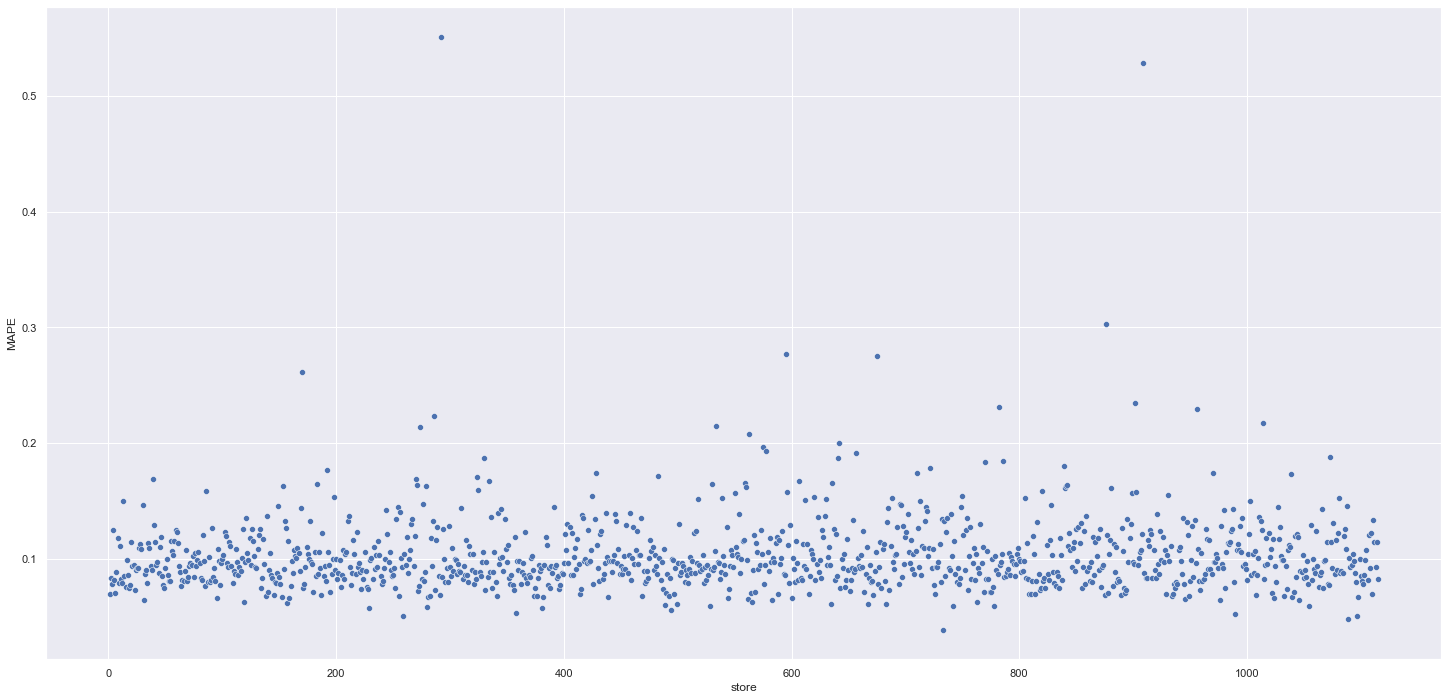

In [96]:
sns.scatterplot(x='store',y='MAPE',data=df92)

## 9.2. Total Performance

In [97]:
df93 = df92[['sales','mean_sales','predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,sales,"R$289,571,750.00"
1,mean_sales,"R$324,608,344.45"
2,predictions,"R$282,756,416.00"
3,worst_scenario,"R$281,970,740.56"
4,best_scenario,"R$283,542,087.76"


## 9.3. Machine Learning Performance

In [98]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

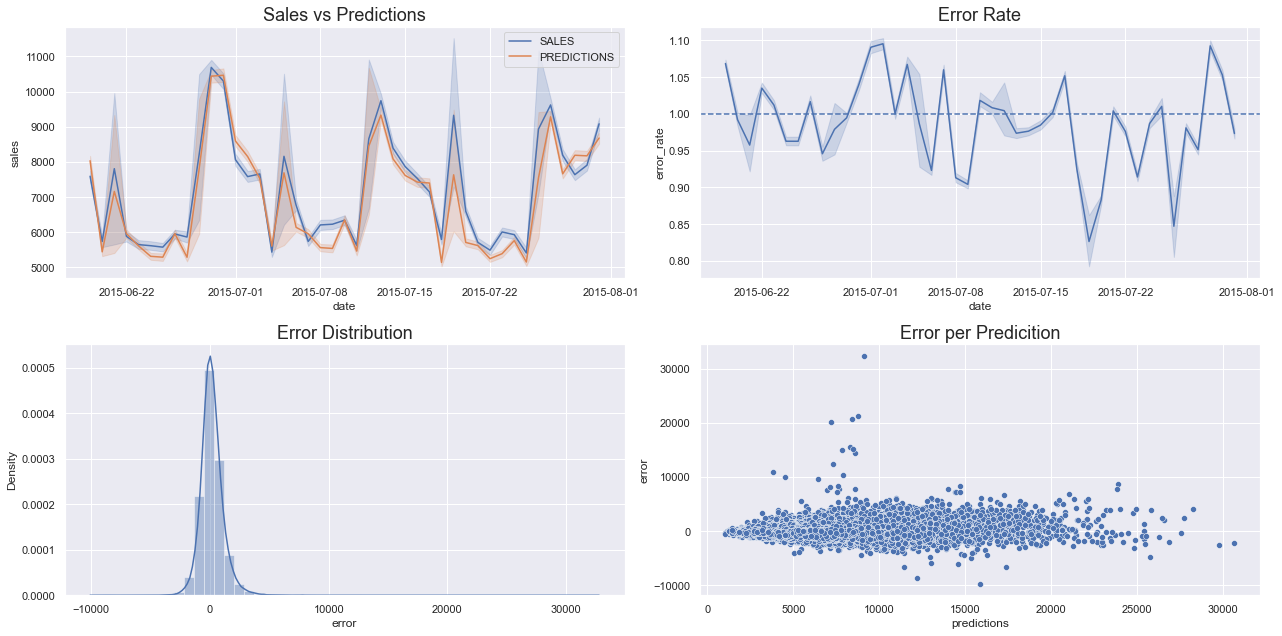

In [104]:
plt.figure(figsize=(18,9))

plt.subplot(2,2,1)
plt.title('Sales vs Predictions',fontsize=18)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')

plt.subplot(2,2,2)
plt.title('Error Rate',fontsize=18)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
plt.title('Error Distribution',fontsize=18)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
plt.title('Error per Predicition',fontsize=18)
sns.scatterplot(df9['predictions'],df9['error'])

plt.tight_layout()

plt.savefig("img//ML_error.png",dpi=600)

# 10. PASSO 10 - DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

In [104]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        state = 1
        self.home.path = 'C:\\Users\\Notebook\\repos\\DS-Producao\\'
        self.competition_distance_scaler = pickle.load(open(self.home.path + 'parameter\\competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home.path + 'parameter\\eulercompetition_distance_scaler.pkl','rb'))
        self.competition_promo_time_week_scaler = pickle.load(open(self.home.path + 'parameter\\competition_distance_scaler.pkl','rb'))
        self.year_scaler = pickle.load(open(self.home.path + 'parameter\\competition_distance_scaler.pkl','rb'))
        self.store_type_scaler = pickle.load(open(self.home.path + 'parameter\\store_type_scaler.pkl','rb'))
        
        
    def data_cleaning(self,df1):
        
        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 
                    'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # rename
        df1.columns = cols_new

        ## 1.3 - Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA

        # competition_distance              
        # Se vazio, não há competidor mais próximo (a distancia até o competidor é mto grande)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2*10**5 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1[['competition_open_since_month','date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year   
        df1['competition_open_since_year'] = df1[['competition_open_since_year','date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week
        df1['promo2_since_week'] = df1[['promo2_since_week','date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year
        df1['promo2_since_year'] = df1[['promo2_since_year','date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval
        month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Out',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6 Change Types

        df1.dtypes

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

        return df1
    
    def feature_engineering( self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of day
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition_sice
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

        # promo sice
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x =='c' else 'regular_day') 

        # 3.0 PASSO 3 - FILTRAGEM DE VARIÁVEIS

        ## 3.1 Filtragem das Linhas

        df2 = df2[(df2['open'] != 0)]

        ## 3.2 Selecao das Colunas

        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self, df5):

        ## 5.2. Rescaling
    
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.competition_promo_time_week_scaler.transform( df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        # store type

        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])
        pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))

        # assortment
        assortment_dict = {'basic':1,'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Nature transformation

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))
        
        cols_select = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month','competition_open_since_year','promo2','promo2_since_week', 
                      'promo2_since_year','competition_time_month', 'promo_time_week','day_of_week_sin','day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos',
                      'week_of_year_sin']
        df5[cols_select]
        
        return df5

    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient = 'records', date_format = 'iso')

## 10.2. API Handler

In [105]:
import pandas as pd 
from flask import Flask, request, Response
# from rossmann.Rossmann import Rossmann

model = pickle.load(open('C:\\Users\\Notebook\\repos\\DS-Producao\\model_rossmann.pkl','rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods = ['POST'])

# initialize API
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance(test_json,dict): #unique example
            test_raw = pd.DataFrame(test_json, index[0])
            
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossamann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # preparation
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        Response('{}', status = 200, mimetype = 'application/json')
        
if __name__ == '__main__':
    app.run('192.168.18.4')
            

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://192.168.18.4:5000 (Press CTRL+C to quit)


## 10.3. API Tester

In [106]:
df10 = pd.read_csv('C:\\Users\\Notebook\\repos\\DS-Producao\\data\\test.csv')

In [107]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on ='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([24])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)
df_test

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
17,24,4,2015-09-17,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
873,24,3,2015-09-16,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
1729,24,2,2015-09-15,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
2585,24,1,2015-09-14,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
4297,24,6,2015-09-12,1.0,0,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
5153,24,5,2015-09-11,1.0,0,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
6009,24,4,2015-09-10,1.0,0,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
6865,24,3,2015-09-09,1.0,0,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
7721,24,2,2015-09-08,1.0,0,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
8577,24,1,2015-09-07,1.0,0,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


In [118]:
data = json.dumps(df_test.to_dict(orient='records'))

In [114]:
# call request
import requests

# url = 'http://192.168.18.4:5000/rossmann/predict'
url = 'https://rossmann-predict-models.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = json.dumps(df_test.to_dict(orient='records'))

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [115]:
# transform dataframe in json
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

In [116]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,6806.601562
1,24,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,16,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,6743.538086
2,24,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,15,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,8144.441406
3,24,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,14,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,8540.610352
4,24,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sept,0,2015,9,12,37,2015-36,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,206,5290.087402


In [157]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R$ {:,.2f} in the next 6 weeks'.format(d2.loc[i,'store'], d2.loc[i,'prediction']))

Store Number 12 will sell R$ 226,313.77 in the next 6 weeks
Store Number 22 will sell R$ 172,358.28 in the next 6 weeks
Store Number 24 will sell R$ 284,016.13 in the next 6 weeks


In [158]:
d2

,store,prediction
0,12,226313.768555
1,22,172358.284668
2,24,284016.133789


In [127]:
df_test

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
7,12,4,2015-09-17,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
15,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
17,24,4,2015-09-17,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
863,12,3,2015-09-16,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
871,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
873,24,3,2015-09-16,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
1719,12,2,2015-09-15,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
1727,22,2,2015-09-15,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
1729,24,2,2015-09-15,1.0,1,0,0,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
2575,12,1,2015-09-14,1.0,1,0,0,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
